In [ ]:
# import the necessary packages
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from random import sample

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
train = {}
test = {}

path = "C:\\Users\\J NEELADRI REDDY\\Downloads\\FOODS"

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "TRAINING")
for i in os.listdir(path_train):
    train[i] = os.listdir(os.path.join(path_train, i))

# Make dictionary storing images for each category under test data.
path_test = os.path.join(path, "VALIDATION")
for i in os.listdir(path_test):
    test[i] = os.listdir(os.path.join(path_test, i))

In [ ]:
# View the number of images in the entire training and testing datasets respectively.
len_train = np.concatenate(list(train.values())).shape[0]
len_test = np.concatenate(list(test.values())).shape[0]

print("Number of images in training data : {}".format(len_train))
print("Number of images in testing data : {}".format(len_test))

Number of images in training data : 9866
Number of images in testing data : 3430


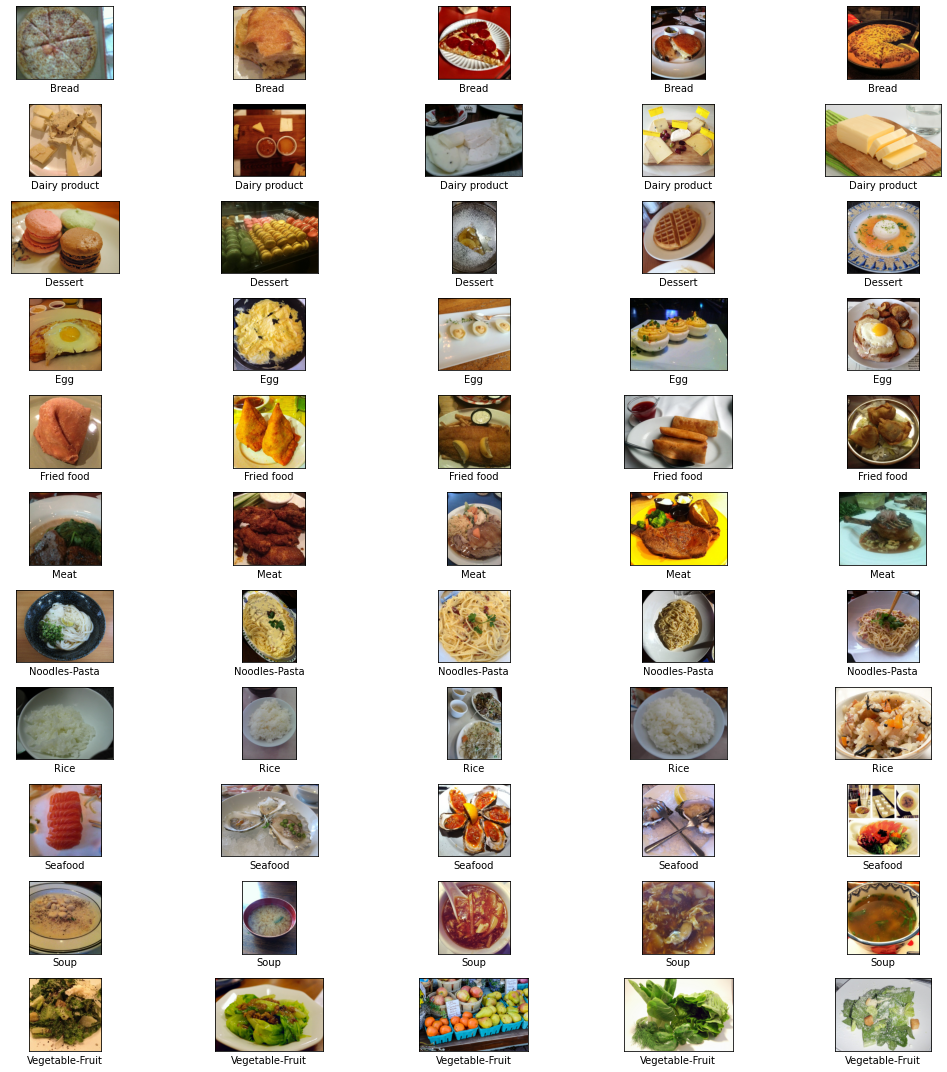

In [ ]:
# Randomly display 5 images under each of the 6 categories from the training data.
fig, axs = plt.subplots(len(train.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(train[item], 5)

    for j, image in enumerate(images):
        img = PIL.Image.open(os.path.join(path_train, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()


In [ ]:
# View the number of images in each of the 6 categories in the training data.
for item in train.keys():
    print(item, len(train[item]))

Bread 994
Dairy product 429
Dessert 1500
Egg 986
Fried food 848
Meat 1325
Noodles-Pasta 440
Rice 280
Seafood 855
Soup 1500
Vegetable-Fruit 709


C:\Users\J NEELADRI REDDY\AppData\Local\Temp\ipykernel_8524\359064173.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


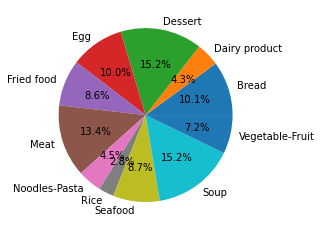

In [ ]:
# Make a pie-chart to visualize the percentage contribution of each category.
fig, ax = plt.subplots()
ax.pie(
    [len(train[item]) for item in train],
    labels = train.keys(),
    autopct = "%1.1f%%"
)
fig.show()

In [ ]:
# Create an Image Generator and specify the type of data augmentation you want to apply.
# Here we go with zooming, flipping (horizontally and vertically), and rescaling.
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create a generator for the images.
# This will make images (including augmented ones) start flowing from the directory to the model.
# Train generator
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [ ]:
# Load the inception resnetv2 model
basemodel = InceptionResNetV2(
    weights = "imagenet",
    include_top = False,
    input_tensor = Input((256, 256, 3))
)

In [ ]:
# print the model summary
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_norm

In [ ]:
# Freeze the basemodel weights, so these weights won't change during training
basemodel.trainable = False

In [ ]:
# Add classification head to the model
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = "Global_Average_Pool")(headmodel)
headmodel = Flatten(name = "flatten")(headmodel)
headmodel = Dense(256, activation = "relu", name = "dense_1")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu", name = "dense_2")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(11, activation = "softmax", name = "output")(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# Compile the model
model.compile(
    loss = "categorical_crossentropy",
    optimizer = SGD(
        lr = 0.01,
        momentum = 0.9
    ),
    metrics = ["accuracy"]
)

In [ ]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1,
    patience = 20
)
# save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights.hdf5",
    verbose = 1,
    save_best_only = True
)


In [ ]:
# Finally, fit the neural network model to the data.
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // 32,
    epochs = 1,
    callbacks = [checkpointer, earlystopping]
)

308/308 [==============================] - ETA: 0s - loss: 1.1629 - accuracy: 0.6208WARNING:tensorflow:Can save best model only with val_loss available, skipping.


308/308 [==============================] - 2326s 7s/step - loss: 1.1629 - accuracy: 0.6208


In [ ]:
#Fine tuning
#Unfreeze the weights in the base model, now these weights will be changed during training
basemodel.trainable = True

In [ ]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1,
    patience = 20
)

# Save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights_fine.hdf5",
    verbose = 1,
    save_best_only = True
)

In [ ]:
# fine tune the model with very low learning rate
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // 32,
    epochs = 5,
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/5
308/308 [==============================] - ETA: 0s - loss: 0.8478 - accuracy: 0.7292WARNING:tensorflow:Can save best model only with val_loss available, skipping.


308/308 [==============================] - 1453s 5s/step - loss: 0.8478 - accuracy: 0.7292
Epoch 2/5
308/308 [==============================] - ETA: 0s - loss: 0.7762 - accuracy: 0.7515WARNING:tensorflow:Can save best model only with val_loss available, skipping.


308/308 [==============================] - 1429s 5s/step - loss: 0.7762 - accuracy: 0.7515
Epoch 3/5
308/308 [==============================] - ETA: 0s - loss: 0.7340 - accuracy: 0.7660WARNING:tensorflow:Can save best model only with val_loss available, skipping.


308/308 [==============================] - 1416s 5s/step - loss: 0.7340 - accuracy: 0.7660
Epoch 4/5
308/308 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.7802WARNING:tensorflow:Can save best model only with val_loss available, skipping.


308/308 [==============================] - 1461s 5s/step - loss: 0.6931 - accuracy: 0.7802
Epoch 5/5
308/308 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.7886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


308/308 [==============================] - 2498s 8s/step - loss: 0.6641 - accuracy: 0.7886


In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate_generator(
    test_generator,
    steps = test_generator.n // 32,
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

C:\Users\J NEELADRI REDDY\AppData\Local\Temp\ipykernel_8524\351863362.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(


107/107 [==============================] - 963s 9s/step - loss: 0.5379 - accuracy: 0.8324
Accuracy Test : 0.832359790802002


In [ ]:
# Assigning label names to the corresponding indexes
labels = {
    0: 'Bread',
    1: 'Dairy product',
    2: 'Dessert',
    3: 'Egg',
    4: 'Fried food',
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice',
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

In [ ]:
# Loading images and their predictions
prediction = []
original = []
image = []
count = 0
path_eval = "C:\\Users\\J NEELADRI REDDY\\Downloads\\FOODS\\EVALUATION"
for i in os.listdir(path_eval):
    for item in os.listdir(os.path.join(path_eval, i)):
        #code to open the image
        img= PIL.Image.open(os.path.join(path_eval, i, item))
        #resizing the image to (256,256)
        img = img.resize((256,256))
        #appending image to the image list
        image.append(img)
        #converting image to array
        img = np.asarray(img, dtype= np.float32)
        #normalizing the image
        img = img / 255
        #reshaping the image in to a 4D array
        img = img.reshape(-1,256,256,3)
        #making prediction of the model
        predict = model.predict(img)
        #getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        #appending the predicted class to the list
        prediction.append(labels[predict])
        #appending original class to the list
        original.append(i)

1/1 [==============================] - 0s 292ms/step


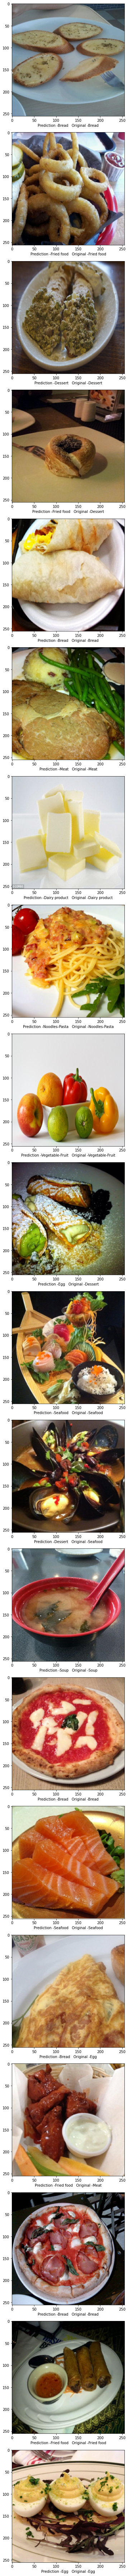

In [ ]:
# Visualizing the results
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
# Check out the Classification Report
print(classification_report(np.asarray(prediction), np.asarray(original)))

                 precision    recall  f1-score   support

          Bread       0.85      0.76      0.80       414
  Dairy product       0.71      0.73      0.72       144
        Dessert       0.75      0.85      0.80       443
            Egg       0.74      0.80      0.77       311
     Fried food       0.80      0.79      0.80       291
           Meat       0.88      0.82      0.85       460
  Noodles-Pasta       0.99      0.97      0.98       149
           Rice       0.97      0.94      0.95        99
        Seafood       0.81      0.95      0.87       258
           Soup       0.97      0.95      0.96       509
Vegetable-Fruit       0.96      0.83      0.89       269

       accuracy                           0.85      3347
      macro avg       0.86      0.85      0.85      3347
   weighted avg       0.85      0.85      0.85      3347



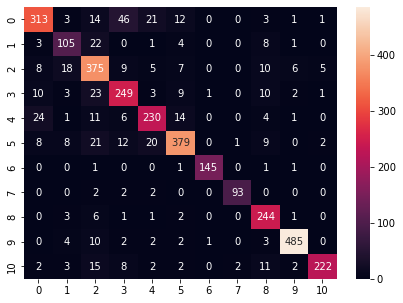

In [ ]:
# View the 6x6 confusion matrix
plt.figure(figsize = (7, 5))
cm = confusion_matrix(np.asarray(prediction), np.asarray(original))
sns.heatmap(
    cm,
    annot = True,
    fmt = "d"
)
plt.show()
